Fitting 10 folds for each of 60 candidates, totalling 600 fits
{'clf__xgb__subsample': 1.0, 'clf__xgb__reg_lambda': 0.5, 'clf__xgb__n_estimators': 300, 'clf__xgb__max_depth': 7, 'clf__xgb__learning_rate': np.float64(0.09), 'clf__xgb__colsample_bytree': 0.7, 'clf__svm__gamma': 'scale', 'clf__svm__C': np.float64(0.01), 'clf__rf__n_estimators': 300, 'clf__rf__min_samples_split': 5, 'clf__rf__min_samples_leaf': 2, 'clf__rf__max_depth': 8, 'clf__final_estimator__C': np.float64(0.21544346900318834)}
CV10_mean_accuracy: 0.83705
HOLDOUT_accuracy: 0.81006
HOLDOUT_f1: 0.75714
HOLDOUT_precision: 0.74648
HOLDOUT_recall: 0.76812
HOLDOUT_roc_auc: 0.85876
              precision    recall  f1-score   support

           0     0.8519    0.8364    0.8440       110
           1     0.7465    0.7681    0.7571        69

    accuracy                         0.8101       179
   macro avg     0.7992    0.8022    0.8006       179
weighted avg     0.8112    0.8101    0.8105       179

CV(5x3)_accuracy: 0.8279

<Figure size 640x480 with 0 Axes>

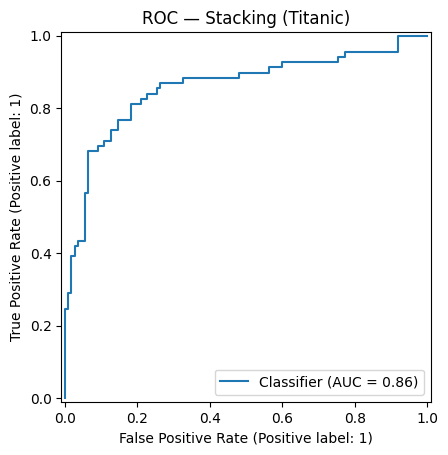

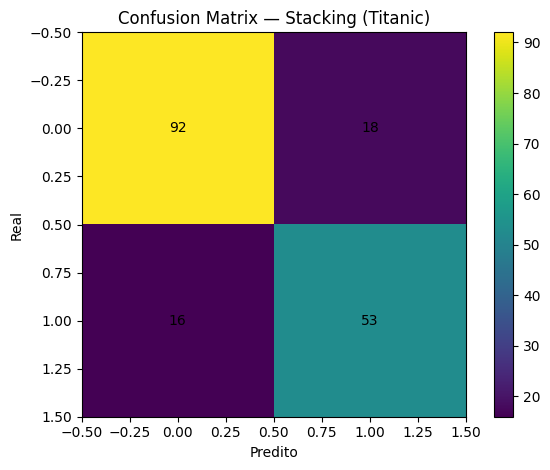

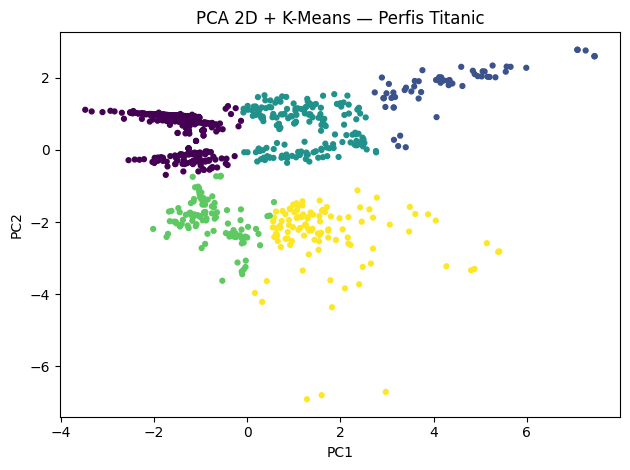

submission.csv gerado


In [2]:
# ============================================================
# Dataset
# ============================================================
from pathlib import Path
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.base import clone
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# ------------------------------------------------------------

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

SEED = 42
np.random.seed(SEED)

TRAIN_PATH = Path(r"C:\Users\ReReu\Downloads\titanic\train.csv")
TEST_PATH  = Path(r"C:\Users\ReReu\Downloads\titanic\test.csv")

train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

# ============================================================
# Features
# ============================================================
def engineer_features(df):
    out = df.copy()
    out["Title"] = out["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
    out["Title"] = out["Title"].replace({
        "Mlle":"Miss","Ms":"Miss","Mme":"Mrs","Lady":"Rare","Countess":"Rare",
        "Capt":"Rare","Col":"Rare","Don":"Rare","Dr":"Rare","Major":"Rare",
        "Rev":"Rare","Sir":"Rare","Jonkheer":"Rare","Dona":"Rare"
    }).fillna("Rare")
    out["FamilySize"] = out["SibSp"] + out["Parch"] + 1
    out["IsAlone"] = (out["FamilySize"] == 1).astype(int)
    out["CabinDeck"] = out["Cabin"].astype(str).str[0].replace({"n":"U"})
    tk = out["Ticket"].astype(str).str.replace(r"[\d\.\/]", "", regex=True).str.replace(" ", "")
    out["TicketPrefix"] = tk.replace({"": "NONE"}).str.upper()
    out["Age*Class"] = out["Age"] * out["Pclass"]
    return out

train_fe = engineer_features(train_df)
test_fe  = engineer_features(test_df)

TARGET = "Survived"
y = train_fe[TARGET]
X = train_fe.drop(columns=[TARGET])

# ============================================================
# Split para validação (holdout) — 20%
# ============================================================
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.20, stratify=y, random_state=SEED)

# ============================================================
# Pré-processamento
# ============================================================
num_cols = ["Pclass","Age","SibSp","Parch","Fare","FamilySize","IsAlone","Age*Class"]
cat_cols = ["Sex","Embarked","Title","CabinDeck","TicketPrefix"]

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_tf = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
cat_tf = make_pipeline(SimpleImputer(strategy="most_frequent"), ohe)

pre = ColumnTransformer([
    ("num", num_tf, num_cols),
    ("cat", cat_tf, cat_cols)
], remainder="drop")

# ============================================================
# Modelos base + Ensemble
# ============================================================
rf_base = RandomForestClassifier(n_estimators=400, random_state=SEED, n_jobs=-1, class_weight="balanced_subsample")
svm_base = SVC(kernel="rbf", probability=True, random_state=SEED, class_weight="balanced", C=1.0, gamma="scale")

estimators = [("rf", rf_base), ("svm", svm_base)]
if HAS_XGB:
    xgb_base = XGBClassifier(
        n_estimators=600, max_depth=5, learning_rate=0.06,
        subsample=0.85, colsample_bytree=0.85, reg_lambda=1.0,
        random_state=SEED, n_jobs=-1, eval_metric="logloss"
    )
    estimators.append(("xgb", xgb_base))

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=400, class_weight="balanced", random_state=SEED),
    stack_method="predict_proba", cv=5, n_jobs=-1
)

pipe = ImbPipeline([
    ("pre", pre),
    ("smote", SMOTE(random_state=SEED)),
    ("clf", stack)
])

# ============================================================
# Busca de hiperparâmetros + CV 10-fold
# ============================================================
param_dist = {
    "clf__final_estimator__C": np.logspace(-2, 2, 10),
    "clf__rf__n_estimators": [300, 500, 800, 1000],
    "clf__rf__max_depth": [None, 5, 8, 12, 16],
    "clf__rf__min_samples_split": [2, 5, 10],
    "clf__rf__min_samples_leaf": [1, 2, 4],
    "clf__svm__C": np.logspace(-2, 2, 10),
    "clf__svm__gamma": ["scale", 0.1, 0.01, 0.001],
}
if HAS_XGB:
    param_dist.update({
        "clf__xgb__n_estimators": [300, 600, 900],
        "clf__xgb__max_depth": [3, 5, 7],
        "clf__xgb__learning_rate": np.linspace(0.03, 0.15, 7),
        "clf__xgb__subsample": [0.7, 0.85, 1.0],
        "clf__xgb__colsample_bytree": [0.7, 0.85, 1.0],
        "clf__xgb__reg_lambda": [0.0, 0.5, 1.0, 3.0],
    })

cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
search = RandomizedSearchCV(estimator=pipe, param_distributions=param_dist,
                            n_iter=60 if HAS_XGB else 45,
                            scoring="accuracy", cv=cv10, n_jobs=-1,
                            random_state=SEED, verbose=1)
search.fit(X_tr, y_tr)

best_pipe = search.best_estimator_
print(search.best_params_)
print("CV10_mean_accuracy:", round(search.best_score_, 5))

# ============================================================
# Avaliação no holdout (20%)
# ============================================================
y_val_pred  = best_pipe.predict(X_val)
y_val_proba = best_pipe.predict_proba(X_val)[:, 1]

print("HOLDOUT_accuracy:", round(accuracy_score(y_val, y_val_pred), 5))
print("HOLDOUT_f1:", round(f1_score(y_val, y_val_pred), 5))
print("HOLDOUT_precision:", round(precision_score(y_val, y_val_pred), 5))
print("HOLDOUT_recall:", round(recall_score(y_val, y_val_pred), 5))
print("HOLDOUT_roc_auc:", round(roc_auc_score(y_val, y_val_proba), 5))
print(classification_report(y_val, y_val_pred, digits=4))

# ============================================================
# Validação Repetida 
# ============================================================
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)
cv_rep = cross_validate(best_pipe, X, y, cv=rskf, scoring=["accuracy","f1","roc_auc"], n_jobs=-1)
print("CV(5x3)_accuracy:", round(cv_rep["test_accuracy"].mean(),5), "±", round(cv_rep["test_accuracy"].std(),5))
print("CV(5x3)_f1:", round(cv_rep["test_f1"].mean(),5), "±", round(cv_rep["test_f1"].std(),5))
print("CV(5x3)_roc_auc:", round(cv_rep["test_roc_auc"].mean(),5), "±", round(cv_rep["test_roc_auc"].std(),5))

# ============================================================
# Importância das variáveis 
# # ============================================================
try:
    feature_names = best_pipe.named_steps["pre"].get_feature_names_out()
except Exception:
    cat = list(best_pipe.named_steps["pre"].transformers_[1][2])
    nums = list(best_pipe.named_steps["pre"].transformers_[0][2])
    feature_names = np.array(nums + cat, dtype=object)

perm = permutation_importance(best_pipe, X_val, y_val, n_repeats=15,
                              random_state=SEED, scoring="accuracy", n_jobs=-1)
imp_df = pd.DataFrame({
    "feature": feature_names[:len(perm.importances_mean)],
    "importance_mean": perm.importances_mean[:len(feature_names)],
    "importance_std": perm.importances_std[:len(feature_names)]
}).sort_values("importance_mean", ascending=False)
print(imp_df.head(15).to_string(index=False))

# ============================================================
# Visualizações (ROC e Matriz de Confusão)
# ============================================================
from pathlib import Path
FIG_DIR = Path("figures"); FIG_DIR.mkdir(exist_ok=True)

plt.figure()
RocCurveDisplay.from_predictions(y_val, y_val_proba)
plt.title("ROC — Stacking (Titanic)")
plt.savefig(FIG_DIR / "roc_curve.png", bbox_inches="tight")
plt.show()

cm = confusion_matrix(y_val, y_val_pred)
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix — Stacking (Titanic)")
plt.xlabel("Predito"); plt.ylabel("Real")
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, str(z), ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.savefig(FIG_DIR / "confusion_matrix.png", bbox_inches="tight")
plt.show()

# ============================================================
# PCA + K-Means
# ============================================================
pre_vis = best_pipe.named_steps["pre"]  
Z = pre_vis.fit_transform(X)

try:
    import scipy.sparse as sp
    if sp.issparse(Z):
        Z = Z.toarray()
except Exception:
    pass

pca = PCA(n_components=2, random_state=SEED)
Z2 = pca.fit_transform(Z)

kmeans = KMeans(n_clusters=5, random_state=SEED, n_init=10)
clusters = kmeans.fit_predict(Z2)

plt.figure()
plt.scatter(Z2[:, 0], Z2[:, 1], c=clusters, s=12)
plt.title("PCA 2D + K-Means — Perfis Titanic")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.savefig(FIG_DIR / "pca_kmeans.png", bbox_inches="tight")
plt.show()

# ============================================================
# Kaggle
# ============================================================
final_model = clone(best_pipe).fit(X, y)
X_test = test_fe[X.columns]
test_pred = final_model.predict(X_test)

submission = pd.DataFrame({"PassengerId": test_df["PassengerId"], "Survived": test_pred.astype(int)})
submission.to_csv("submission.csv", index=False)
print("submission.csv gerado")


## Features
Foram criadas novas colunas: Title, FamilySize, IsAlone, CabinDeck, TicketPrefix e Age*Class.  
Ideia é aumentar o contexto dos passageiros e dar mais informação pro modelo.  

## Holdout
Separação 80/20 com estratificação.  
Serve pra ter um teste fora da validação cruzada.  
A média da CV ficou em 0.837 e no holdout deu 0.810, mostrando diferença entre treino e teste.  

## Pré-processamento
Numéricos tratados com mediana e padronização.  
Categóricos tratados com mais frequente e OneHotEncoder.  
Tudo dentro do pipeline para não vazar informação.  

## Modelos
Usados Random Forest, SVM e XGBoost.  
Uma Regressão Logística combinou as previsões dos três modelos.  
SMOTE e class_weight foram aplicados para lidar com desbalanceamento.  

## Tuning + CV
O melhor conjunto encontrado foi:  
- Random Forest com 300 árvores e profundidade 8  
- SVM com C baixo e gamma scale  
- XGBoost com 300 árvores, profundidade 7 e learning rate ~0.09  
- Regressão Logística final com C ~0.21  
Cada modelo contribuiu de forma diferente.  

## Holdout
Resultados: Accuracy 0.810, F1 0.757, Precision 0.746, Recall 0.768, AUC 0.858.  
Mostra equilíbrio entre métricas e bom desempenho geral.  

## Validação Repetida
Resultados médios: Accuracy 0.8279 ±0.025, F1 0.772 ±0.033, AUC 0.878 ±0.020.  
Baixa variação entre repetições, indicando estabilidade.  

## Importância
As variáveis com maior peso foram Embarked_Q, Parch, Fare, Age e FamilySize.  
Isso mostra que informações de embarque, família e tarifa tiveram grande impacto.  

## Visualizações
Foram gerados gráficos para avaliar e explorar os resultados:  
- **Curva ROC**: mostra a qualidade da classificação.  
- **Matriz de Confusão**: evidencia os acertos e erros do modelo.  
- **PCA + K-Means**: agrupa passageiros em perfis, ajudando a visualizar padrões.  

## Submissão
O modelo final foi treinado no conjunto inteiro e o arquivo submission.csv foi gerado.  
